# Testing registration methods on Vivek's data

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.ndimage import affine_transform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from otimage import imagerep, readers
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load data

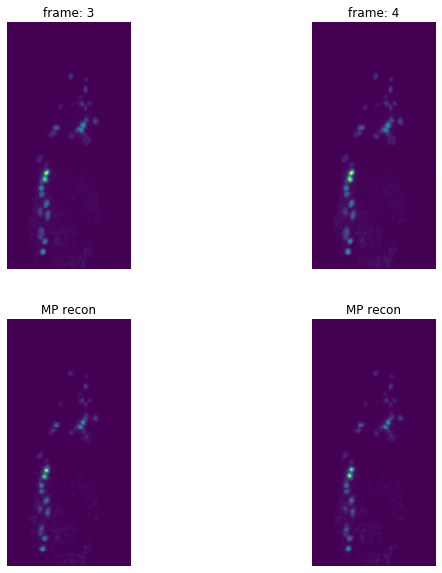

In [3]:
# Frame index
t1 = 3
t2 = 4

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormTraces/data/Vivek/1024_tail_06/data.mat'
with readers.VivekReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    img_shape = img_1.shape

# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/vivek/1024_tail_06/mp_components/mp_0000_0900.mat'
mp_data = loadmat(mp_path)
cov = mp_data['cov']
pts_1 = mp_data['means'][t1, :, :]
pts_2 = mp_data['means'][t2, :, :]
wts_1 = mp_data['weights'][t1, :, 0]
wts_2 = mp_data['weights'][t2, :, 0]

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_image(pts_1, [cov], wts_1, img_shape)
rec_2 = imagerep.reconstruct_image(pts_2, [cov], wts_2, img_shape)
  
plt.figure(figsize=(10, 10))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Run OT registration on images 

In [4]:
model, debug = gw_registration(pts_1, pts_2, wts_1, wts_2, degree=3, n_iter=75)

beta = model.named_steps['linear'].coef_
print('beta (est):')
print(beta)

beta (est):
[[ 4.94877200e+01 -1.25812154e+00  2.09438105e-01 -5.05220722e+00
   4.46537476e-02 -1.08119110e-02  2.83277076e-02  2.01319866e-03
  -1.60183848e-02  4.58440518e-01 -2.28250181e-04  7.04334189e-05
  -7.95978713e-04 -3.82227004e-05  8.34081934e-04  8.45235394e-05
   7.71323931e-06 -1.55698126e-04 -6.25882988e-04 -9.88430927e-03]
 [-1.91516509e+01  9.46065488e-01  9.85964100e-01  1.21465120e+00
  -3.72479240e-02  9.49623711e-03  1.94577504e-01 -5.78179709e-04
  -5.26692471e-02 -4.92158811e-01  3.13521771e-04 -1.23600469e-04
  -1.44125583e-03  1.52481035e-05  5.46701729e-04 -2.79582311e-03
  -2.15711615e-06  2.08468657e-05  5.60916284e-04  1.80811585e-02]
 [ 9.27635865e+00 -3.36851713e-03 -1.45845125e-02 -1.90252913e+00
   1.03636685e-03  2.00077550e-04 -1.03933533e-02  3.96371321e-04
   9.33859427e-04  2.69829554e-01  2.53076883e-05 -3.67541942e-05
  -2.18041353e-04  7.04452334e-06  2.25999193e-04  8.00839515e-04
  -1.44550851e-06 -2.74500182e-05 -3.97645690e-04 -8.87859557e

## Reconstruct second frame using mapping

### MP space

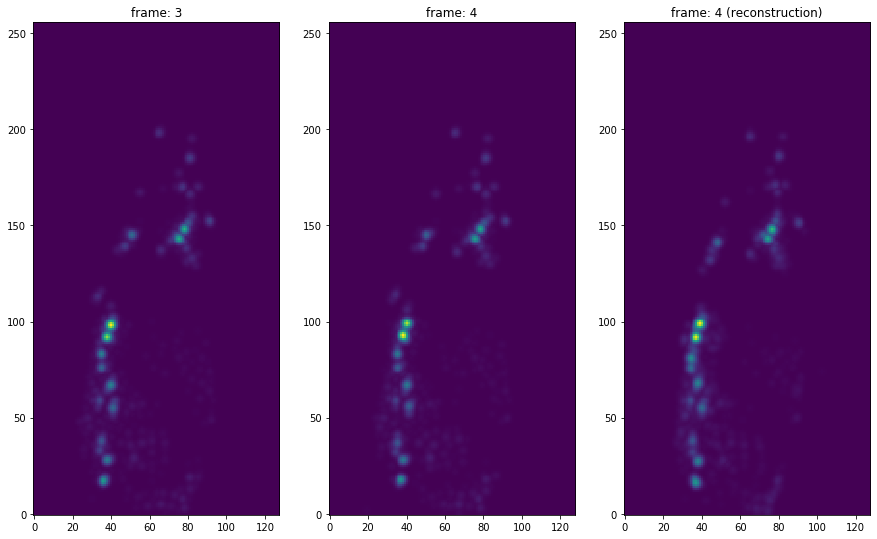

In [5]:
# Transform MP points for first image using mapping
map_pts = model.predict(pts_1).astype(int)

# Reconstruct image from transformed points
map_mp = imagerep.reconstruct_image_2(map_pts, wts_1, cov, img_shape)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(map_mp)
plt.title(f'frame: {t2} (reconstruction)');

## Changes in mapping over iterations

### Coordinates of single MP point

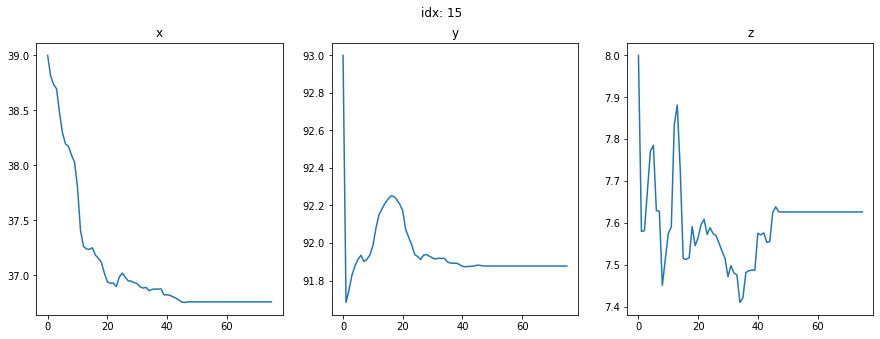

In [6]:
idx = 15

x_vals = [p[idx, 0] for p in debug['pf_pts']]
y_vals = [p[idx, 1] for p in debug['pf_pts']]
z_vals = [p[idx, 2] for p in debug['pf_pts']]

plt.figure(figsize=(15, 5))
plt.suptitle(f'idx: {idx}')

plt.subplot(131)
plt.plot(x_vals)
plt.title('x')

plt.subplot(132)
plt.plot(y_vals)
plt.title('y')

plt.subplot(133)
plt.plot(z_vals);
plt.title('z');

### MP reconstruction of entire image

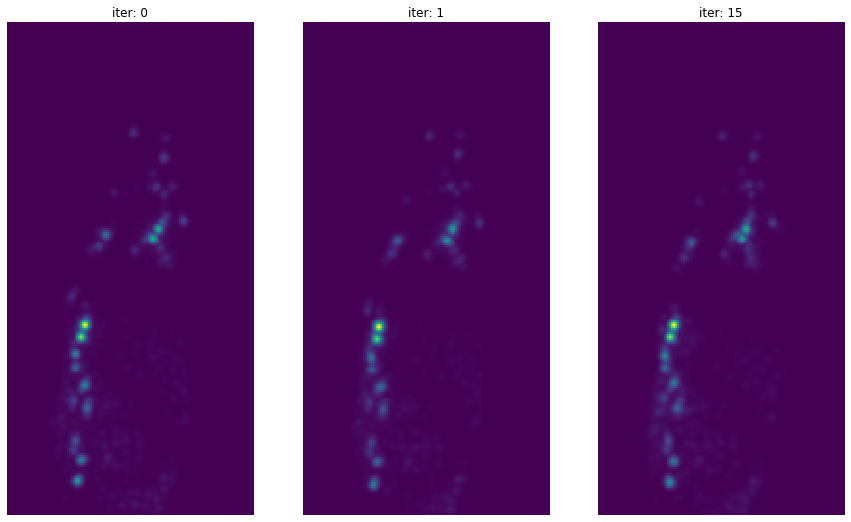

In [7]:
iters = [0, 1, 15]

trans_rec = [imagerep.reconstruct_image_2(debug['pf_pts'][i], wts_1, cov, img_shape) for i in iters]

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(trans_rec[0])
plt.title(f'iter: {iters[0]}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj(trans_rec[1])
plt.title(f'iter: {iters[1]}')
plt.axis('off')
        
plt.subplot(133)
plot_maxproj(trans_rec[2])
plt.title(f'iter: {iters[2]}')
plt.axis('off');